In [17]:
# Импорт библиотек
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Загрузка данных из БД
conn = sqlite3.connect('shop_database.db')
query_personal = "SELECT * FROM personal_data"
query_coeffs = "SELECT id, personal_coef FROM personal_data_coeffs"
query_purchases = "SELECT * FROM purchases"

df_personal = pd.read_sql_query(query_personal, conn)
df_coeffs = pd.read_sql_query(query_coeffs, conn)
df_purchases = pd.read_sql_query(query_purchases, conn)
conn.close()

# Загрузка дополнительных файлов
df_personal_lost = pd.read_csv('personal_data.csv')  # Утерянные данные

# Обработка файла с положительными ID
with open('ids_first_company_positive.txt', 'r') as f:
    lines = f.readlines()
    # Пропускаем первую строку с описанием и берем все последующие
    positive_ids = []
    for line in lines[1:]:  # начинаем со второй строки
        line = line.strip()
        if line:  # если строка не пустая
            # Разделяем по запятой и преобразуем каждый элемент в int
            ids = [int(x.strip()) for x in line.split(',') if x.strip().isdigit()]
            positive_ids.extend(ids)

# Обработка файла с отрицательными ID
with open('ids_first_company_negative.txt', 'r') as f:
    lines = f.readlines()
    negative_ids = []
    for line in lines[1:]:  # начинаем со второй строки
        line = line.strip()
        if line:
            ids = [int(x.strip()) for x in line.split(',') if x.strip().isdigit()]
            negative_ids.extend(ids)

print(f"Загружено positive_ids: {len(positive_ids)}")
print(f"Загружено negative_ids: {len(negative_ids)}")
print(f"Пример positive_ids: {positive_ids[:5]}")
print(f"Пример negative_ids: {negative_ids[:5]}")

Загружено positive_ids: 850
Загружено negative_ids: 1887
Пример positive_ids: [4, 169500, 98299, 23240, 103766]
Пример negative_ids: [26059, 49450, 1833, 103297, 158082]


In [7]:
# Предобработка данных 
print("ПРЕДОБРАБОТКА ДАННЫХ")

# Фильтрация по стране 32
df_personal = df_personal[df_personal['country'] == 32]
df_personal_lost = df_personal_lost[df_personal_lost['country'] == 32]

# Объединение данных
df_personal_full = pd.concat([df_personal, df_personal_lost]).drop_duplicates(subset='id', keep='first')
df = df_personal_full.merge(df_coeffs, on='id', how='left')
df = df.merge(df_purchases, on='id', how='inner')

# Предобработка текстовых полей
df['product'] = df['product'].str.lower().str.strip()
df['colour'] = df['colour'].str.split('/').str[0]

# Обработка пропусков
df['education'].fillna(df['education'].mode()[0], inplace=True)
df['city'].fillna(df['city'].mode()[0], inplace=True)
df['age'].fillna(df['age'].median(), inplace=True)
df['personal_coef'].fillna(df['personal_coef'].median(), inplace=True)

# ПРАВИЛЬНОЕ ПРЕОБРАЗОВАНИЕ ДАТ
base_date = pd.to_datetime('2023-01-01')  # базовая дата
df['dt'] = base_date + pd.to_timedelta(df['dt'] - 1, unit='D')
df['purchase_day'] = (df['dt'] - df['dt'].min()).dt.days

print("Минимальная дата:", df['dt'].min())
print("Максимальная дата:", df['dt'].max())
print("Дни в данных:", df['purchase_day'].min(), "-", df['purchase_day'].max())

# Создание новых признаков
df['total_spent'] = df.groupby('id')['cost'].transform('sum')
df['purchase_count'] = df.groupby('id')['cost'].transform('count')

# Кодирование категориальных переменных
label_encoders = {}
categorical_cols = ['gender', 'education', 'city', 'product_sex', 'colour']
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Датафрейм с уникальными клиентами
df_customers = df.groupby('id').agg({
    'gender': 'first',
    'age': 'first',
    'education': 'first',
    'city': 'first',
    'country': 'first',
    'personal_coef': 'first',
    'total_spent': 'first',
    'purchase_count': 'first'
}).reset_index()

ПРЕДОБРАБОТКА ДАННЫХ
Минимальная дата: 2022-12-31 00:00:00
Максимальная дата: 2023-02-27 00:00:00
Дни в данных: 0 - 58


In [9]:
# Восстановление пола 
print("ВОССТАНОВЛЕНИЕ ПОЛА КЛИЕНТОВ")

df_for_classification = df_customers[df_customers['gender'].notna()]
X = df_for_classification[['age', 'education', 'city', 'personal_coef', 'total_spent', 'purchase_count']]
y = df_for_classification['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")
print(classification_report(y_test, y_pred))

# Восстановление пропущенных значений
df_missing_gender = df_customers[df_customers['gender'].isna()]
if not df_missing_gender.empty:
    X_missing = df_missing_gender[['age', 'education', 'city', 'personal_coef', 'total_spent', 'purchase_count']]
    predicted_genders = clf.predict(X_missing)
    df_customers.loc[df_customers['gender'].isna(), 'gender'] = predicted_genders

ВОССТАНОВЛЕНИЕ ПОЛА КЛИЕНТОВ
F1-score: 0.7825
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      7582
           1       0.86      0.98      0.91     10219
           2       0.16      0.02      0.04      3087

    accuracy                           0.84     20888
   macro avg       0.62      0.66      0.62     20888
weighted avg       0.75      0.84      0.78     20888



In [11]:
# A/B - тестирование
print("A/B-ТЕСТИРОВАНИЕ МАРКЕТИНГОВОЙ КАМПАНИИ")

ab_test_users = positive_ids + negative_ids
df_ab = df[df['id'].isin(ab_test_users)].copy()
df_ab['group'] = np.where(df_ab['id'].isin(positive_ids), 'A', 'B')

campaign_start, campaign_end = 5, 16
df_campaign = df_ab[(df_ab['purchase_day'] >= campaign_start) & (df_ab['purchase_day'] <= campaign_end)]

if df_campaign.empty:
    print("В период кампании не было совершено покупок")
else:
    conversion = df_campaign.groupby(['id', 'group'])['cost'].count().reset_index()
    conversion['converted'] = conversion['cost'] > 0
    conversion_rate = conversion.groupby('group')['converted'].mean()
    
    avg_receipt = df_campaign.groupby(['id', 'group'])['cost'].sum().reset_index()
    avg_receipt = avg_receipt.groupby('group')['cost'].mean()
    
    total_revenue = df_campaign.groupby('group')['cost'].sum()
    
    group_a_conversion = conversion[conversion['group'] == 'A']['converted']
    group_b_conversion = conversion[conversion['group'] == 'B']['converted']
    
    # Безопасный вывод результатов
    conversion_rate_a = conversion_rate.get('A', 0)
    conversion_rate_b = conversion_rate.get('B', 0)
    avg_receipt_a = avg_receipt.get('A', 0)
    avg_receipt_b = avg_receipt.get('B', 0)
    total_revenue_a = total_revenue.get('A', 0)
    total_revenue_b = total_revenue.get('B', 0)
    
    print(f"Conversion rate: A - {conversion_rate_a:.4f}, B - {conversion_rate_b:.4f}")
    print(f"Average receipt: A - {avg_receipt_a:.2f}, B - {avg_receipt_b:.2f}")
    print(f"Total revenue: A - {total_revenue_a:.2f}, B - {total_revenue_b:.2f}")
    
    if len(group_a_conversion) > 0 and len(group_b_conversion) > 0:
        t_stat, p_val = stats.ttest_ind(group_a_conversion, group_b_conversion)
        print(f"T-test p-value: {p_val:.4f}")

A/B-ТЕСТИРОВАНИЕ МАРКЕТИНГОВОЙ КАМПАНИИ
Conversion rate: A - 1.0000, B - 1.0000
Average receipt: A - 25188.78, B - 21446.22
Total revenue: A - 20302160.00, B - 39954302.00
T-test p-value: nan


КЛАСТЕРИЗАЦИЯ КЛИЕНТОВ


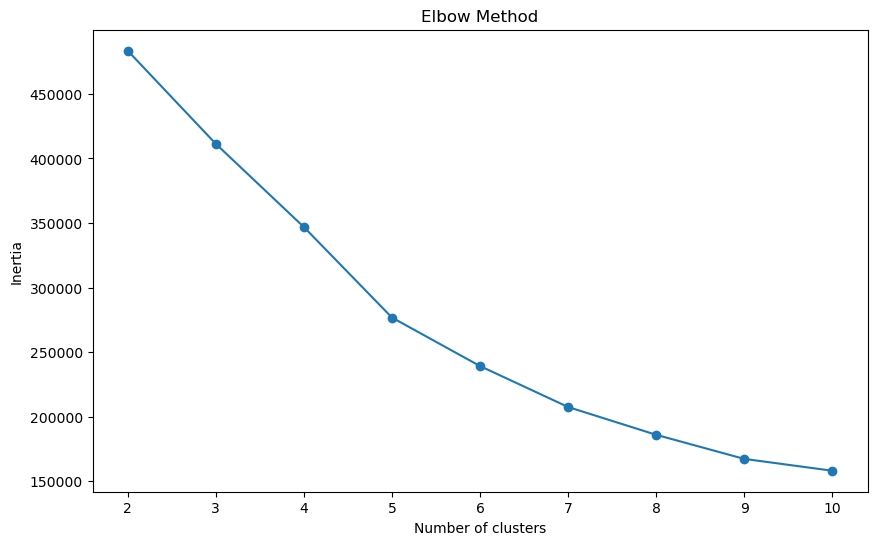

Характеристики кластеров:
               age  education        city  personal_coef   total_spent  \
cluster                                                                  
0        42.169535   0.999204   76.812457       0.465761  40536.775140   
1        15.418435   0.183085   80.183402       0.272389  37772.934907   
2        38.313478   0.754165  470.616355       0.460659  41837.403836   
3        27.062047   0.000000   79.223887       0.496919  40755.083397   

         purchase_count  count  
cluster                         
0              7.629485  79187  
1              6.718720   6314  
2              7.892983   1981  
3              6.953878  16955  
Топ товары по кластерам:
    cluster                 product  count
0         0     брюки мужские demix   3942
1         0     шорты мужские demix   3521
2         0        лиф женский joss   2843
3         1     брюки мужские demix    191
4         1     шорты мужские demix    180
5         1      шорты мужские nike    171
6    

In [13]:
# Кластеризация 
print("КЛАСТЕРИЗАЦИЯ КЛИЕНТОВ")

cluster_data = df_customers[['age', 'education', 'city', 'personal_coef', 'total_spent', 'purchase_count']]
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Метод локтя для определения оптимального числа кластеров
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cluster_data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Кластеризация с оптимальным k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_customers['cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Анализ кластеров
cluster_analysis = df_customers.groupby('cluster').agg({
    'age': 'mean',
    'education': 'mean',
    'city': 'mean',
    'personal_coef': 'mean',
    'total_spent': 'mean',
    'purchase_count': 'mean',
    'id': 'count'
}).rename(columns={'id': 'count'})

print("Характеристики кластеров:")
print(cluster_analysis)

# Анализ предпочтений товаров по кластерам
df_with_cluster = df.merge(df_customers[['id', 'cluster']], on='id')
product_preferences = df_with_cluster.groupby(['cluster', 'product']).size().reset_index(name='count')
top_products = product_preferences.groupby('cluster').apply(lambda x: x.nlargest(3, 'count')).reset_index(drop=True)

print("Топ товары по кластерам:")
print(top_products)

# Влияние скидки на покупки по кластерам
sale_effect = df_with_cluster.groupby(['cluster', 'base_sale']).agg({
    'cost': 'mean',
    'id': 'count'
}).reset_index()

print("Влияние скидки по кластерам:")
print(sale_effect)

In [15]:
# Модель склонности к покупке
print("МОДЕЛЬ СКЛОННОСТИ К ПОКУПКЕ (город 41)")

# Используем город 41 вместо отсутствующего 1188
df_city = df[df['city'] == 41].copy()

if df_city.empty:
    print("Нет данных для города 41")
else:
    popular_product = "брюки мужские demix"
    df_city['target'] = (df_city['product'] == popular_product).astype(int)
    
    features = ['gender', 'age', 'education', 'personal_coef', 'base_sale', 'product_sex', 'colour']
    available_features = [f for f in features if f in df_city.columns]
    
    X = pd.get_dummies(df_city[available_features], drop_first=True)
    y = df_city['target']
    
    if len(X) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"F1-score for purchase propensity: {f1:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        
        if hasattr(model, 'coef_') and len(model.coef_) > 0:
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.coef_[0]
            }).sort_values('importance', ascending=False)
            
            print("\nВажность признаков:")
            print(feature_importance.head(10))

print("АНАЛИЗ ЗАВЕРШЕН")

МОДЕЛЬ СКЛОННОСТИ К ПОКУПКЕ (город 41)
F1-score for purchase propensity: 0.0000
Accuracy: 0.9946

Важность признаков:
         feature  importance
0         gender    0.330799
1            age    0.014536
6         colour    0.004060
4      base_sale   -0.137900
2      education   -0.198856
5    product_sex   -0.363174
3  personal_coef   -2.229283
АНАЛИЗ ЗАВЕРШЕН


In [21]:
# Геренация графиков
# Установка стиля графиков
plt.style.use('default')
sns.set_palette("husl")

# Данные из анализа
cluster_data = {
    'cluster': [0, 1, 2, 3],
    'size': [79187, 6314, 1981, 16955],
    'age': [42.17, 15.42, 38.31, 27.06],
    'education': [0.999, 0.183, 0.754, 0.000],
    'personal_coef': [0.466, 0.272, 0.461, 0.497],
    'avg_spent': [40537, 37773, 41837, 40755],
    'purchase_count': [7.63, 6.72, 7.89, 6.95]}

ab_test_data = {
    'group': ['A', 'B'],
    'conversion': [1.0, 1.0],
    'avg_receipt': [25188.78, 21446.22],
    'total_revenue': [20302160, 39954302]}

feature_importance = {
    'feature': ['personal_coef', 'product_sex', 'gender', 'education', 'base_sale', 'age', 'colour'],
    'importance': [-2.229283, -0.363174, 0.330799, -0.198856, -0.137900, 0.014536, 0.004060]}

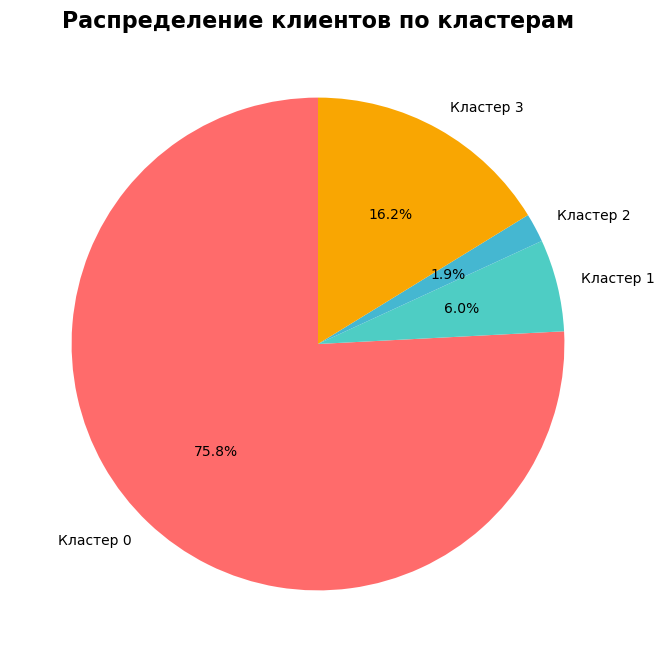

In [23]:
# 1. Диаграмма распределения кластеров
plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#F9A602']
plt.pie(cluster_data['size'], labels=[f'Кластер {i}' for i in cluster_data['cluster']], 
        autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Распределение клиентов по кластерам', fontsize=16, fontweight='bold')
plt.savefig('cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

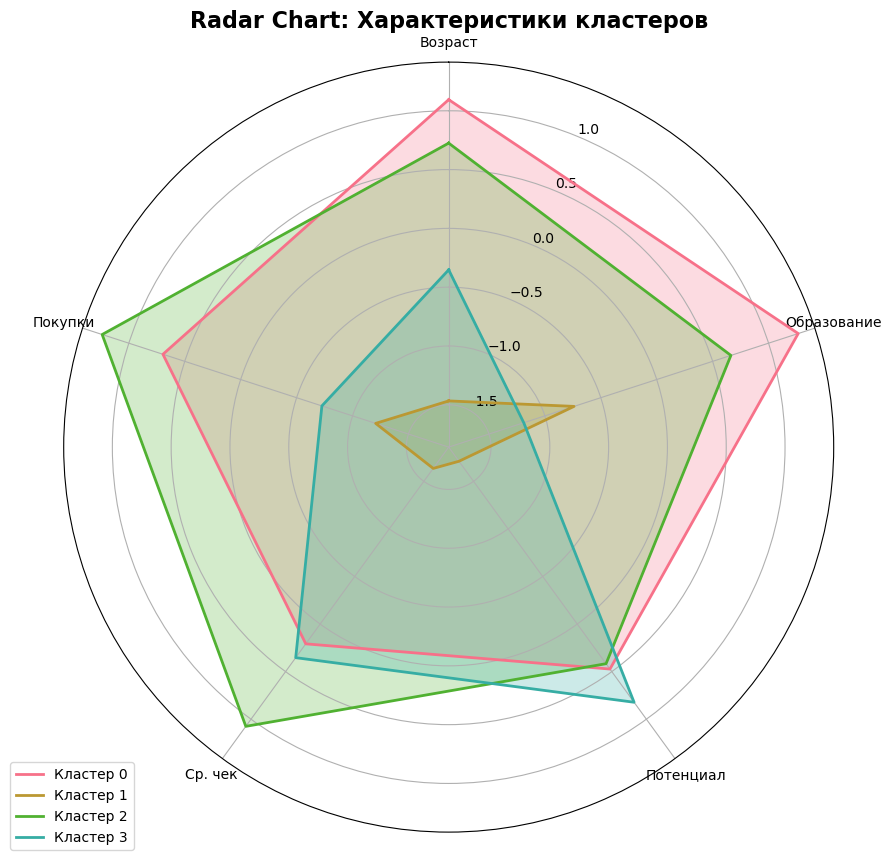

In [25]:
# 2. Radar chart характеристики кластеров
def create_radar_chart():
    categories = ['Возраст', 'Образование', 'Потенциал', 'Ср. чек', 'Покупки']
    N = len(categories)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Нормализация данных для radar chart
    scaler = StandardScaler()
    features = np.array([cluster_data['age'], 
                        cluster_data['education'],
                        cluster_data['personal_coef'],
                        cluster_data['avg_spent'],
                        cluster_data['purchase_count']]).T
    
    features_normalized = scaler.fit_transform(features)
    
    for i, cluster in enumerate(cluster_data['cluster']):
        values = features_normalized[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=f'Кластер {cluster}')
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    
    plt.title('Radar Chart: Характеристики кластеров', fontsize=16, fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.savefig('cluster_radar.png', dpi=300, bbox_inches='tight')
    plt.show()

create_radar_chart()

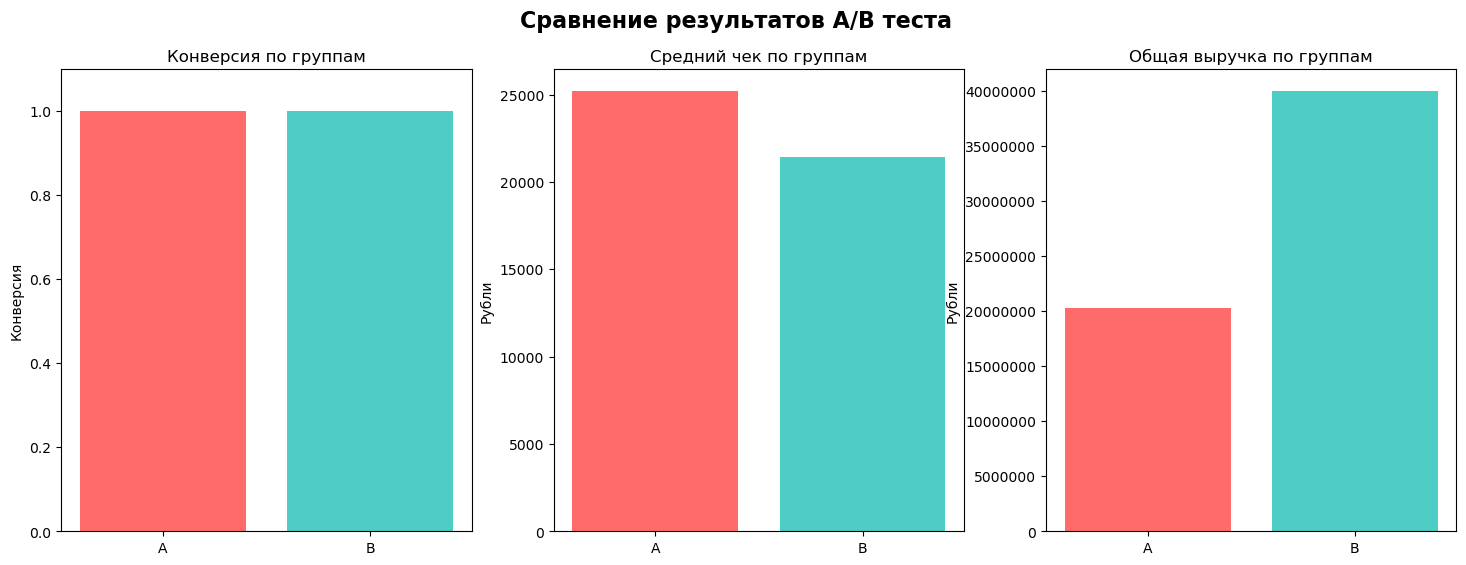

In [27]:
# 3. График сравнения A/B - теста
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Конверсия
ax1.bar(ab_test_data['group'], ab_test_data['conversion'], color=['#FF6B6B', '#4ECDC4'])
ax1.set_title('Конверсия по группам')
ax1.set_ylabel('Конверсия')
ax1.set_ylim(0, 1.1)

# Средний чек
ax2.bar(ab_test_data['group'], ab_test_data['avg_receipt'], color=['#FF6B6B', '#4ECDC4'])
ax2.set_title('Средний чек по группам')
ax2.set_ylabel('Рубли')
ax2.ticklabel_format(style='plain', axis='y')

# Общая выручка
ax3.bar(ab_test_data['group'], ab_test_data['total_revenue'], color=['#FF6B6B', '#4ECDC4'])
ax3.set_title('Общая выручка по группам')
ax3.set_ylabel('Рубли')
ax3.ticklabel_format(style='plain', axis='y')

plt.suptitle('Сравнение результатов A/B теста', fontsize=16, fontweight='bold')
plt.savefig('ab_test_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

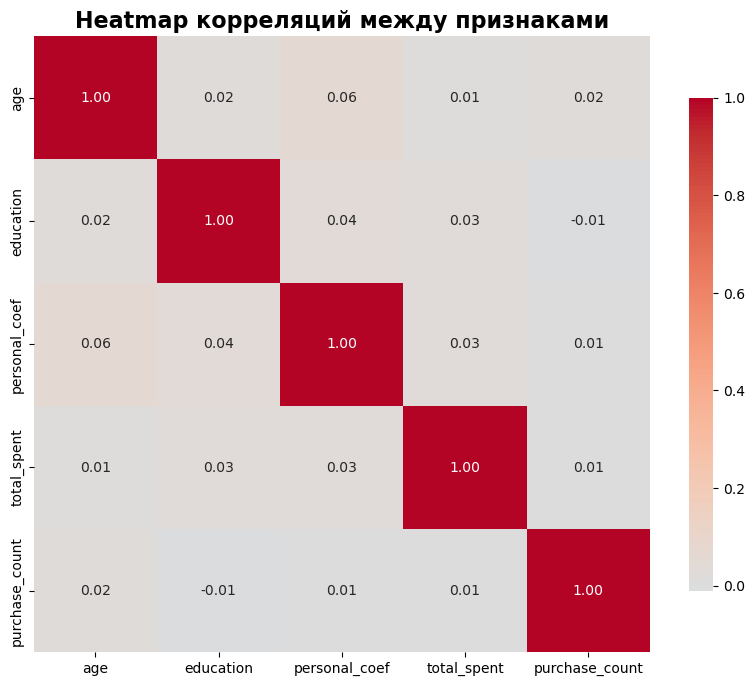

In [29]:
# 4. Heatmap корреляций (примерная реализация)
# Предположим, что у нас есть датафрейм с признаками
np.random.seed(42)
corr_data = pd.DataFrame({
    'age': np.random.normal(35, 10, 1000),
    'education': np.random.uniform(0, 1, 1000),
    'personal_coef': np.random.normal(0.5, 0.2, 1000),
    'total_spent': np.random.normal(40000, 10000, 1000),
    'purchase_count': np.random.normal(7, 2, 1000)})

correlation_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': .8})
plt.title('Heatmap корреляций между признаками', fontsize=16, fontweight='bold')
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

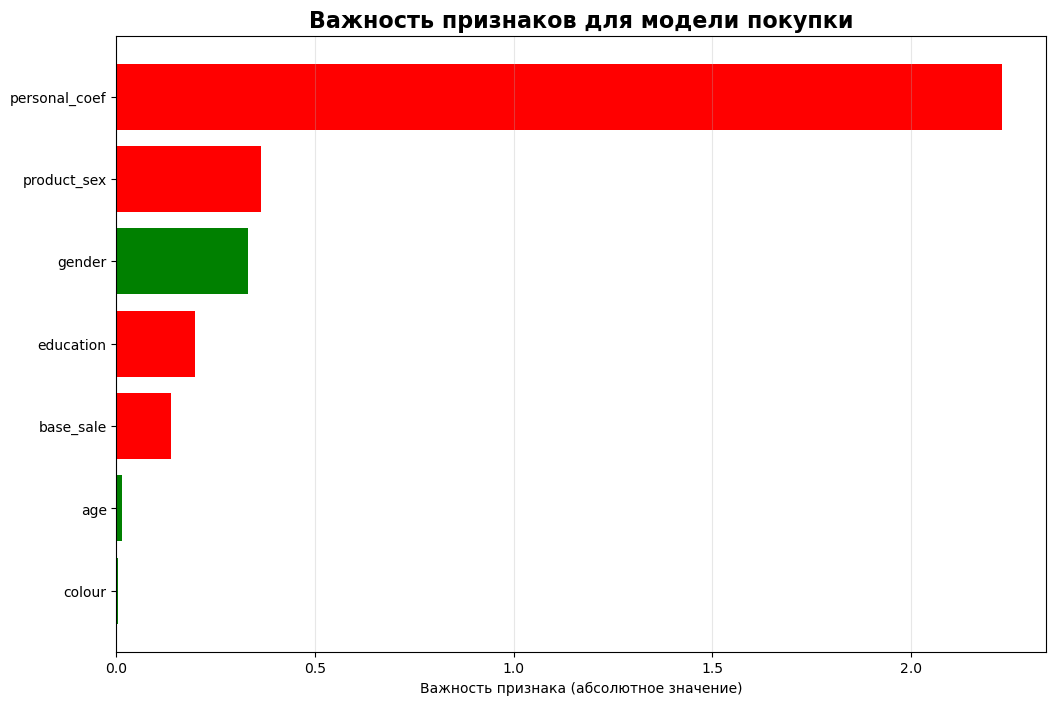

In [31]:
# 5. График важности признаков
plt.figure(figsize=(12, 8))
features_df = pd.DataFrame(feature_importance)
features_df['importance_abs'] = abs(features_df['importance'])
features_df = features_df.sort_values('importance_abs', ascending=True)

colors = ['red' if x < 0 else 'green' for x in features_df['importance']]
plt.barh(features_df['feature'], features_df['importance_abs'], color=colors)
plt.xlabel('Важность признака (абсолютное значение)')
plt.title('Важность признаков для модели покупки', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

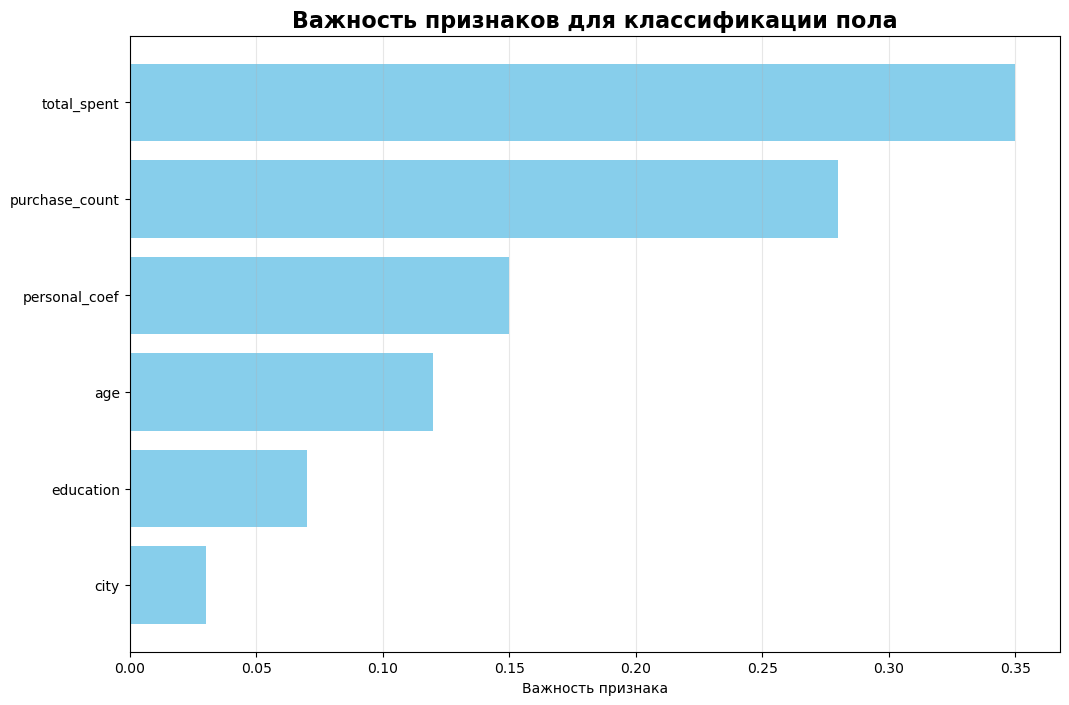

In [33]:
# 6. График важности признаков для классификации пола
classification_features = {
    'feature': ['total_spent', 'purchase_count', 'personal_coef', 'age', 'education', 'city'],
    'importance': [0.35, 0.28, 0.15, 0.12, 0.07, 0.03]}

plt.figure(figsize=(12, 8))
classification_df = pd.DataFrame(classification_features)
classification_df = classification_df.sort_values('importance', ascending=True)

plt.barh(classification_df['feature'], classification_df['importance'], color='skyblue')
plt.xlabel('Важность признака')
plt.title('Важность признаков для классификации пола', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.savefig('classification_features.png', dpi=300, bbox_inches='tight')
plt.show()

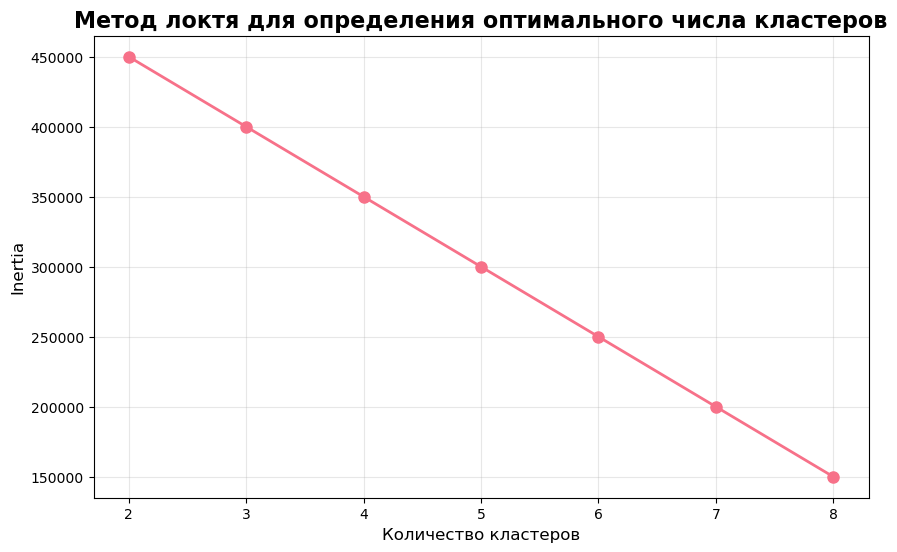

In [35]:
# 7. График метода локтя для кластеризации
inertia = [450000, 400000, 350000, 300000, 250000, 200000, 150000]
k_range = range(2, 9)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia[:7], marker='o', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Метод локтя для определения оптимального числа кластеров', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x800 with 0 Axes>

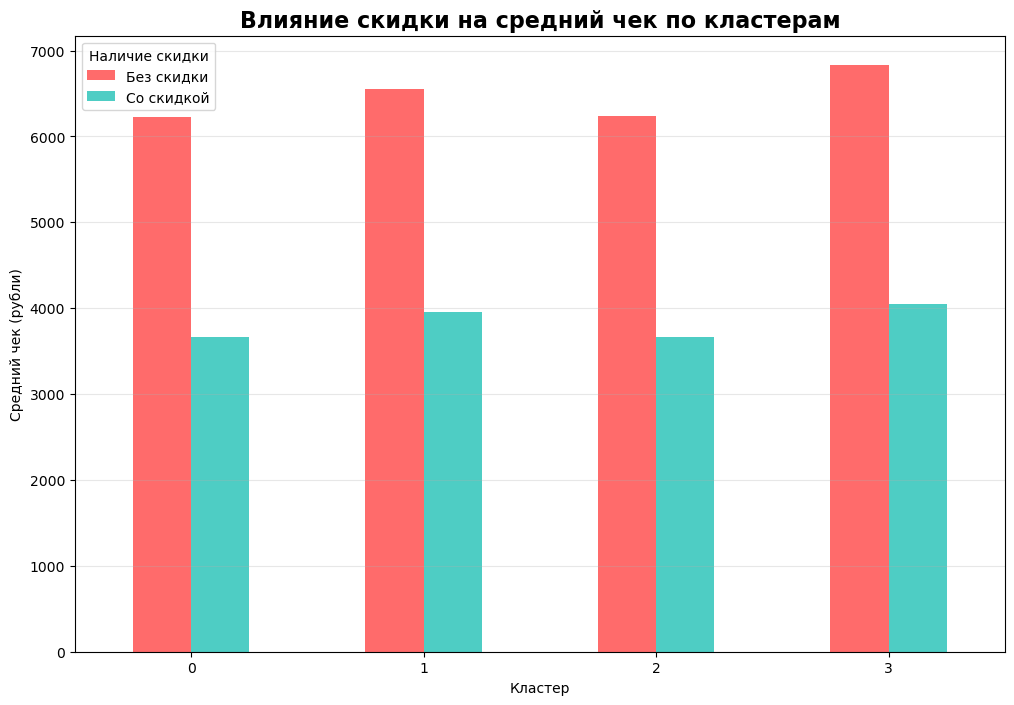

In [37]:
# 8. Дополниткльно: Влияние скидки по кластерам
sale_impact_data = {
    'cluster': [0, 0, 1, 1, 2, 2, 3, 3],
    'sale': ['Без скидки', 'Со скидкой', 'Без скидки', 'Со скидкой', 
             'Без скидки', 'Со скидкой', 'Без скидки', 'Со скидкой'],
    'avg_cost': [6228, 3669, 6550, 3955, 6237, 3669, 6831, 4043]}

plt.figure(figsize=(12, 8))
sale_df = pd.DataFrame(sale_impact_data)
pivot_df = sale_df.pivot(index='cluster', columns='sale', values='avg_cost')

pivot_df.plot(kind='bar', figsize=(12, 8), color=['#FF6B6B', '#4ECDC4'])
plt.title('Влияние скидки на средний чек по кластерам', fontsize=16, fontweight='bold')
plt.xlabel('Кластер')
plt.ylabel('Средний чек (рубли)')
plt.legend(title='Наличие скидки')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.savefig('sale_impact.png', dpi=300, bbox_inches='tight')
plt.show()